# Week 2: Spike-Stimulus Analysis

This notebook covers methods for analyzing the relationship between neural spiking
and behavioral variables. We'll focus on **place cells** - hippocampal neurons that
fire preferentially when an animal is at specific locations.

Using the same dataset from Week 1 ([Petersen & Buzsáki, 2020](https://pmc.ncbi.nlm.nih.gov/articles/PMC7442698/)),
we'll examine how neural firing relates to the animal's position during spatial navigation.

## Learning Objectives

By the end of this notebook, you will be able to:

1. Load position data and spike times from an NWB file
2. Construct a peri-stimulus time histogram (PSTH) aligned to behavioral events
3. Visualize a neuron's spatial firing pattern
4. Compute and interpret a place field

## Setup

In [23]:
# Install dependencies (required for Google Colab)
import subprocess
import sys

if "google.colab" in sys.modules:
    subprocess.check_call(
        [
            sys.executable,
            "-m",
            "pip",
            "install",
            "-q",
            "pynwb",
            "hdmf",
            "dandi",
            "remfile",
            "h5py",
            "fsspec",
            "aiohttp",
            "requests",
        ]
    )

In [24]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
from dandi.dandiapi import DandiAPIClient
from pynwb import NWBHDF5IO
from remfile import File as RemoteFile
from scipy.signal import correlate
from scipy.stats import gaussian_kde

## Load Data from DANDI

We'll stream the same dataset from Week 1.

In [25]:
# Define the dataset location on DANDI
DANDISET_ID = "000059"
DANDISET_VERSION = "0.230907.2101"
ASSET_PATH = (
    "sub-MS22/"
    "sub-MS22_ses-Peter-MS22-180629-110319-concat_desc-processed_behavior+ecephys.nwb"
)

In [26]:
# Connect to DANDI and get the streaming URL
with DandiAPIClient() as client:
    dandiset = client.get_dandiset(DANDISET_ID, DANDISET_VERSION)
    asset = dandiset.get_asset_by_path(ASSET_PATH)
    s3_url = asset.get_content_url(follow_redirects=1, strip_query=True)

print(f"Streaming from: {s3_url[:80]}...")

Streaming from: https://dandiarchive.s3.amazonaws.com/blobs/075/b32/075b32be-1c44-4e2f-8a91-3eeb...


In [27]:
# Open the NWB file for streaming
remote_file = RemoteFile(s3_url)
h5_file = h5py.File(remote_file, "r")
io = NWBHDF5IO(file=h5_file, load_namespaces=True)
nwbfile = io.read()

print(f"Session: {nwbfile.identifier}")

Session: 7931d1a7-09c5-457f-9f0a-22d952d8b818


## Load Position Data

Position tracking is fundamental to studying spatial navigation. In this experiment,
the animal's location was tracked using an overhead camera while it ran on a figure-8
maze. The position data includes:

- **X and Y coordinates** in centimeters
- **Timestamps** for each position sample (typically 30-60 Hz)

We need position data to determine *where* the animal was when each spike occurred.
This allows us to ask: does this neuron fire preferentially at certain locations?

In [28]:
# Get the behavior module and extract position
behavior_module = nwbfile.processing["behavior"]

position_interface = next(
    interface
    for name, interface in behavior_module.data_interfaces.items()
    if "position" in name.lower()
)

spatial_series = next(iter(position_interface.spatial_series.values()))

# Load position data and timestamps
position_data = spatial_series.data[:]
position_timestamps = spatial_series.timestamps[:]

x_position = position_data[:, 0]
y_position = position_data[:, 1]

print(f"Position data shape: {position_data.shape}")
print(f"Time range: {position_timestamps[0]:.1f} - {position_timestamps[-1]:.1f} s")

Position data shape: (198664, 3)
Time range: 6348.1 - 8003.6 s


## Select a Good Unit

Spike sorting algorithms attempt to assign each detected spike to a specific neuron,
but not all assignments are equally reliable. Units are typically classified as:

- **good**: Well-isolated single neurons with clear waveforms and refractory periods
- **mua** (multi-unit activity): Spikes from multiple neurons that couldn't be separated
- **noise**: Artifacts or poorly isolated signals

For place cell analysis, we use only well-isolated units ("good" quality) because
we need confidence that we're analyzing the activity of a single neuron. A place
field that appears to have multiple peaks might actually be two different neurons
with different place fields, which would be misleading.

In [29]:
# Get units and filter for good quality
units_df = nwbfile.units.to_dataframe()

good_unit_mask = units_df["quality"].isin(["good", "good2"])
good_unit_indices = np.where(good_unit_mask)[0]

print(f"Total units: {len(units_df)}")
print(f"Good units: {len(good_unit_indices)}")

Total units: 1509
Good units: 172


In [30]:
# Select a unit to analyze
unit_idx = good_unit_indices[3]

# Get spike times for this unit
spike_times = nwbfile.units["spike_times"][unit_idx]

print(f"Unit {unit_idx}:")
print(f"  Number of spikes: {len(spike_times)}")
print(f"  Firing rate: {len(spike_times) / (spike_times[-1] - spike_times[0]):.2f} Hz")

Unit 598:
  Number of spikes: 6526
  Firing rate: 0.54 Hz


## Aligning Spikes to Behavior

Neural recordings often span a longer time period than the behavioral task. The spike
times cover the entire recording session, but position tracking only occurs during
the maze-running epoch.

Before analyzing spatial firing, we need to:
1. Identify which spikes occurred during position tracking
2. Find the animal's position at the time of each spike

The green and red dashed lines below show the start and end of position tracking.
Only spikes between these lines can be used for place field analysis.

Text(0.5, 1.0, 'Spike Raster for Unit 598')

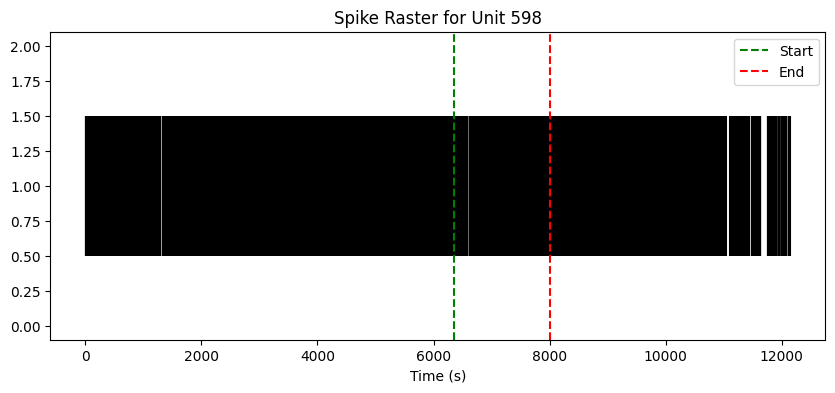

In [31]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.eventplot(spike_times, lineoffsets=1, colors="black")
ax.axvline(position_timestamps.min(), color="green", linestyle="--", label="Start")
ax.axvline(position_timestamps.max(), color="red", linestyle="--", label="End")
ax.set_xlabel("Time (s)")
ax.legend()
ax.set_title(f"Spike Raster for Unit {unit_idx}")

## Inter-Spike Interval (ISI) Distribution

The **inter-spike interval (ISI)** is the time between consecutive spikes from the
same neuron. The ISI distribution reveals important properties of neural firing:

- **Refractory period** (0-2 ms): Real neurons cannot fire again immediately after
  a spike due to biophysical constraints. A gap near zero confirms good isolation.
- **Bursting** (2-10 ms): Some neurons, especially hippocampal pyramidal cells,
  fire in rapid bursts. Peaks in this range indicate bursty firing.
- **Longer intervals**: Reflect the neuron's baseline firing rate and modulation
  by behavioral or cognitive states.

The ISI histogram is also a quality control check: if there are many intervals
shorter than the refractory period (~1-2 ms), the unit may contain spikes from
multiple neurons.

(0.0, 0.5)

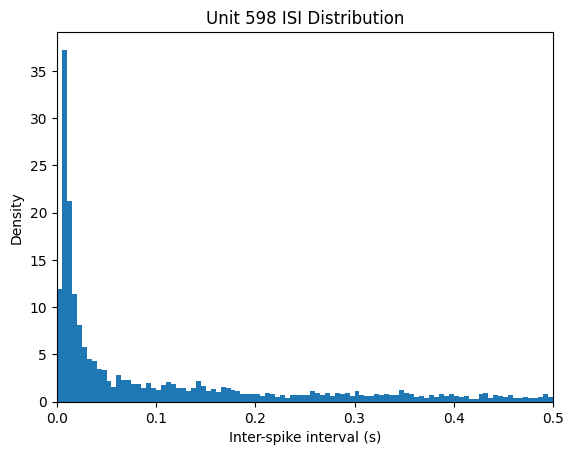

In [32]:
isi = np.diff(spike_times)
isi_max = 0.5  # seconds (500 ms)
isi = isi[isi < isi_max]  # Filter out long ISIs for better visualization
fig, ax = plt.subplots()
isi_bin_size = 0.005  # seconds (5 ms bins)
bins = np.arange(0, isi_max + isi_bin_size, isi_bin_size)

ax.hist(isi, bins=bins, density=True)
ax.set_xlabel("Inter-spike interval (s)")
ax.set_ylabel("Density")
ax.set_title(f"Unit {unit_idx} ISI Distribution")
ax.set_xlim(0, isi_max)

## Peri-Stimulus Time Histogram (PSTH)

A **peri-stimulus time histogram (PSTH)** shows the average firing rate of a neuron
aligned to repeated behavioral events. This is a fundamental tool for understanding
how neurons respond to stimuli or behavioral events.

In this experiment, the animal performed a spatial alternation task on a figure-8
maze. Each trial involves:
1. Starting from a reward location
2. Running through the central arm
3. Choosing left or right at the choice point
4. Receiving reward for correct alternation (or not, for errors)

We can align spikes to **trial onset** and ask: does the neuron fire differently
on left vs. right choice trials? This reveals whether the neuron encodes the
animal's trajectory or choice direction.

In [33]:
# Load trial information
trials_df = nwbfile.trials.to_dataframe()
print(f"Number of trials: {len(trials_df)}")
print(f"\nTrial columns: {list(trials_df.columns)}")
print(f"\nError rate: {trials_df['error'].mean():.1%}")
print("\nTrials by condition:")
print(trials_df.groupby(["condition", "error"]).size())

Number of trials: 143

Trial columns: ['start_time', 'stop_time', 'condition', 'error', 'cooling state']

Error rate: 7.7%

Trials by condition:
condition  error
Left       False    60
           True      9
Right      False    72
           True      2
dtype: int64


In [34]:
# Define PSTH parameters
psth_window = (-1.0, 3.0)  # seconds relative to trial start
psth_bin_size = 0.05  # 50 ms bins
psth_bins = np.arange(psth_window[0], psth_window[1] + psth_bin_size, psth_bin_size)
bin_centers = psth_bins[:-1] + psth_bin_size / 2


def compute_trial_aligned_spikes(spike_times, trial_times, window):
    """Align spike times to trial events.

    Parameters
    ----------
    spike_times : np.ndarray
        Array of spike times in seconds.
    trial_times : np.ndarray
        Array of trial onset times in seconds.
    window : tuple
        (start, end) window relative to trial onset.

    Returns
    -------
    list of np.ndarray
        Spike times relative to each trial onset.
    """
    aligned_spikes = []
    for t in trial_times:
        # Find spikes within the window around this trial
        mask = (spike_times >= t + window[0]) & (spike_times <= t + window[1])
        aligned_spikes.append(spike_times[mask] - t)
    return aligned_spikes


# Separate trials by choice direction
left_trials = trials_df[trials_df["condition"] == "Left"]
right_trials = trials_df[trials_df["condition"] == "Right"]

# Compute aligned spikes for each condition
left_aligned = compute_trial_aligned_spikes(
    spike_times, left_trials["start_time"].values, psth_window
)
right_aligned = compute_trial_aligned_spikes(
    spike_times, right_trials["start_time"].values, psth_window
)

print(f"Left trials: {len(left_aligned)}")
print(f"Right trials: {len(right_aligned)}")

Left trials: 69
Right trials: 74


In [35]:
# Compute PSTH (spike counts per bin, averaged across trials)
def compute_psth(aligned_spikes, bins):
    """Compute peri-stimulus time histogram.

    Parameters
    ----------
    aligned_spikes : list of np.ndarray
        Spike times relative to each trial onset.
    bins : np.ndarray
        Bin edges for the histogram.

    Returns
    -------
    np.ndarray
        Mean firing rate in each bin (spikes/second).
    """
    bin_size = bins[1] - bins[0]
    counts = np.zeros(len(bins) - 1)
    for spikes in aligned_spikes:
        counts += np.histogram(spikes, bins=bins)[0]
    # Convert to firing rate (spikes/s)
    return counts / len(aligned_spikes) / bin_size


left_psth = compute_psth(left_aligned, psth_bins)
right_psth = compute_psth(right_aligned, psth_bins)

# Define colors for each condition
LEFT_COLOR = "#0072B2"  # blue
RIGHT_COLOR = "#D55E00"  # vermillion

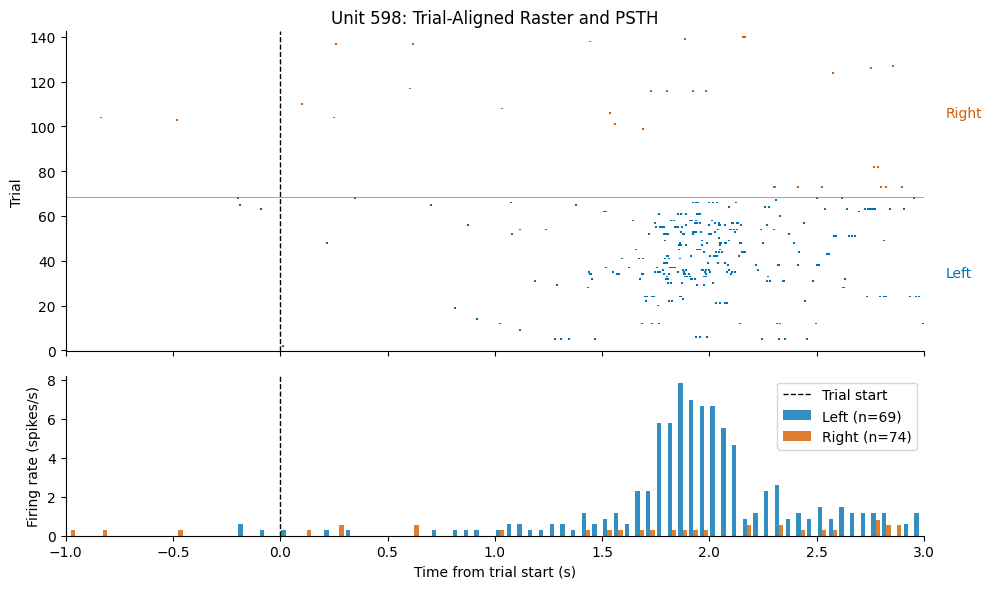

In [36]:
# Plot raster and PSTH comparing left vs right trials
fig, axes = plt.subplots(
    2, 1, figsize=(10, 6), sharex=True, gridspec_kw={"height_ratios": [2, 1]}
)

# Top panel: Raster plot sorted by trial type
ax_raster = axes[0]

# Plot left trials first (bottom of raster)
trial_offset = 0
for i, spikes in enumerate(left_aligned):
    ax_raster.eventplot(
        spikes, lineoffsets=trial_offset + i, linelengths=0.8, colors=LEFT_COLOR
    )
n_left = len(left_aligned)

# Plot right trials above left trials
for i, spikes in enumerate(right_aligned):
    ax_raster.eventplot(
        spikes, lineoffsets=n_left + i, linelengths=0.8, colors=RIGHT_COLOR
    )

# Add horizontal line separating trial types
ax_raster.axhline(n_left - 0.5, color="gray", linestyle="-", linewidth=0.5)
ax_raster.axvline(0, color="black", linestyle="--", linewidth=1)

ax_raster.set(
    ylabel="Trial",
    title=f"Unit {unit_idx}: Trial-Aligned Raster and PSTH",
    ylim=(-0.5, len(left_aligned) + len(right_aligned) - 0.5),
)
ax_raster.spines[["top", "right"]].set_visible(False)

# Add trial type labels on the right
ax_raster.text(
    psth_window[1] + 0.1, n_left / 2, "Left", color=LEFT_COLOR, va="center", fontsize=10
)
ax_raster.text(
    psth_window[1] + 0.1,
    n_left + len(right_aligned) / 2,
    "Right",
    color=RIGHT_COLOR,
    va="center",
    fontsize=10,
)

# Bottom panel: PSTH histogram
ax_psth = axes[1]

ax_psth.bar(
    bin_centers - psth_bin_size * 0.2,
    left_psth,
    width=psth_bin_size * 0.4,
    alpha=0.8,
    label=f"Left (n={len(left_aligned)})",
    color=LEFT_COLOR,
)
ax_psth.bar(
    bin_centers + psth_bin_size * 0.2,
    right_psth,
    width=psth_bin_size * 0.4,
    alpha=0.8,
    label=f"Right (n={len(right_aligned)})",
    color=RIGHT_COLOR,
)

ax_psth.axvline(0, color="black", linestyle="--", linewidth=1, label="Trial start")
ax_psth.set(
    xlabel="Time from trial start (s)",
    ylabel="Firing rate (spikes/s)",
    xlim=psth_window,
)
ax_psth.legend(loc="upper right")
ax_psth.spines[["top", "right"]].set_visible(False)

plt.tight_layout()
plt.show()

The raster plot (top) shows individual spikes on each trial, sorted by trial type.
The PSTH (bottom) averages across trials to reveal the typical firing pattern.

Key observations to look for:

- **Pre-trial activity**: Is there anticipatory firing before the trial starts?
- **Trial-locked response**: Does firing rate change sharply at trial onset?
- **Left vs. right differences**: Does the neuron fire more on one trajectory?

For place cells, the PSTH pattern depends on where the neuron's place field is
located. If the place field is on the left arm, the neuron will fire more on
left trials. If it's in the central arm (before the choice point), left and
right trials should look similar. This connects the temporal (PSTH) and spatial
(place field) views of the same neuron's activity.

## Effect of Bin Size on PSTH

The choice of bin size affects the PSTH appearance:

- **Small bins** (e.g., 10 ms): High temporal resolution but noisy due to few spikes per bin
- **Large bins** (e.g., 200 ms): Smooth but may obscure rapid changes in firing rate

There's a tradeoff between temporal precision and statistical reliability. Let's
visualize this using the left trials only.

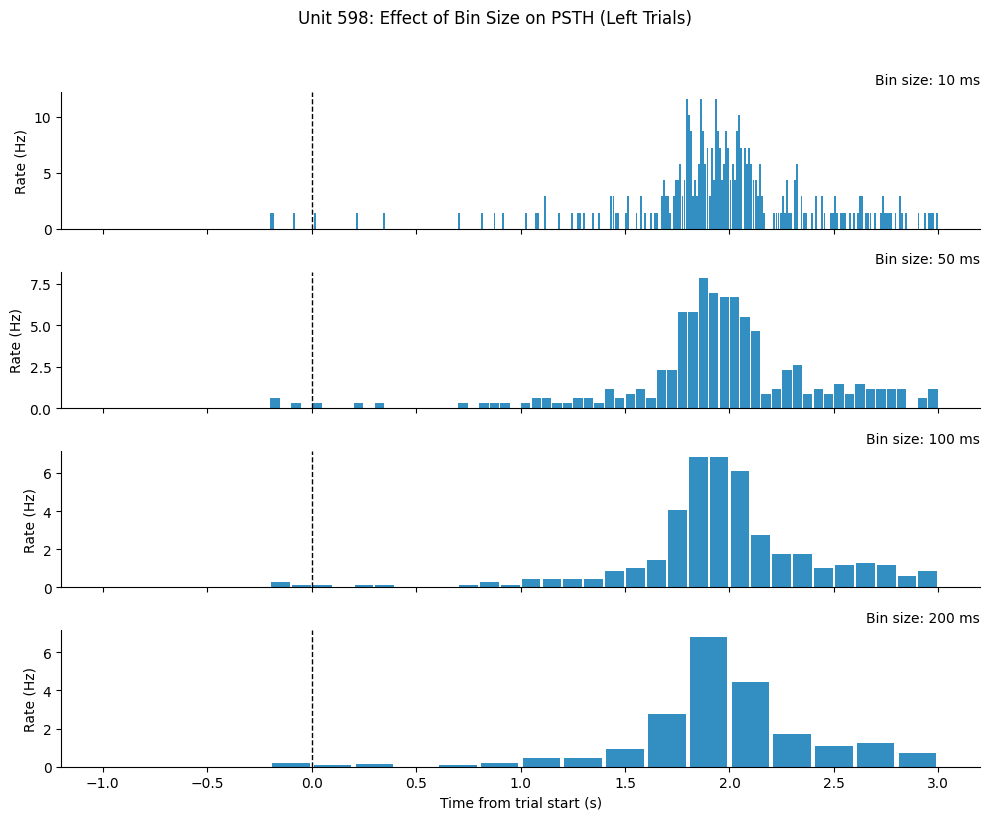

In [37]:
# Compare different bin sizes
bin_sizes = [0.01, 0.05, 0.1, 0.2]  # 10, 50, 100, 200 ms

fig, axes = plt.subplots(len(bin_sizes), 1, figsize=(10, 8), sharex=True)

for ax, bin_size in zip(axes, bin_sizes):
    bins = np.arange(psth_window[0], psth_window[1] + bin_size, bin_size)
    centers = bins[:-1] + bin_size / 2
    psth = compute_psth(left_aligned, bins)

    ax.bar(centers, psth, width=bin_size * 0.9, color=LEFT_COLOR, alpha=0.8)
    ax.axvline(0, color="black", linestyle="--", linewidth=1)
    ax.set_ylabel("Rate (Hz)")
    ax.set_title(f"Bin size: {int(bin_size * 1000)} ms", loc="right", fontsize=10)
    ax.spines[["top", "right"]].set_visible(False)

axes[-1].set_xlabel("Time from trial start (s)")
fig.suptitle(f"Unit {unit_idx}: Effect of Bin Size on PSTH (Left Trials)", y=1.02)

plt.tight_layout()
plt.show()

Notice how smaller bins reveal finer temporal structure but are noisier, while
larger bins are smoother but may miss brief changes in firing rate. A common
choice is 20-50 ms, which balances resolution and reliability.

## Kernel Density Estimation (KDE)

An alternative to histograms is **kernel density estimation (KDE)**, which
smooths the spike times with a continuous kernel (typically Gaussian). This
avoids the arbitrary bin edge placement and produces a smooth firing rate estimate.

The bandwidth (kernel width) plays a similar role to bin size:
- **Small bandwidth**: High resolution but noisy
- **Large bandwidth**: Smooth but may over-smooth

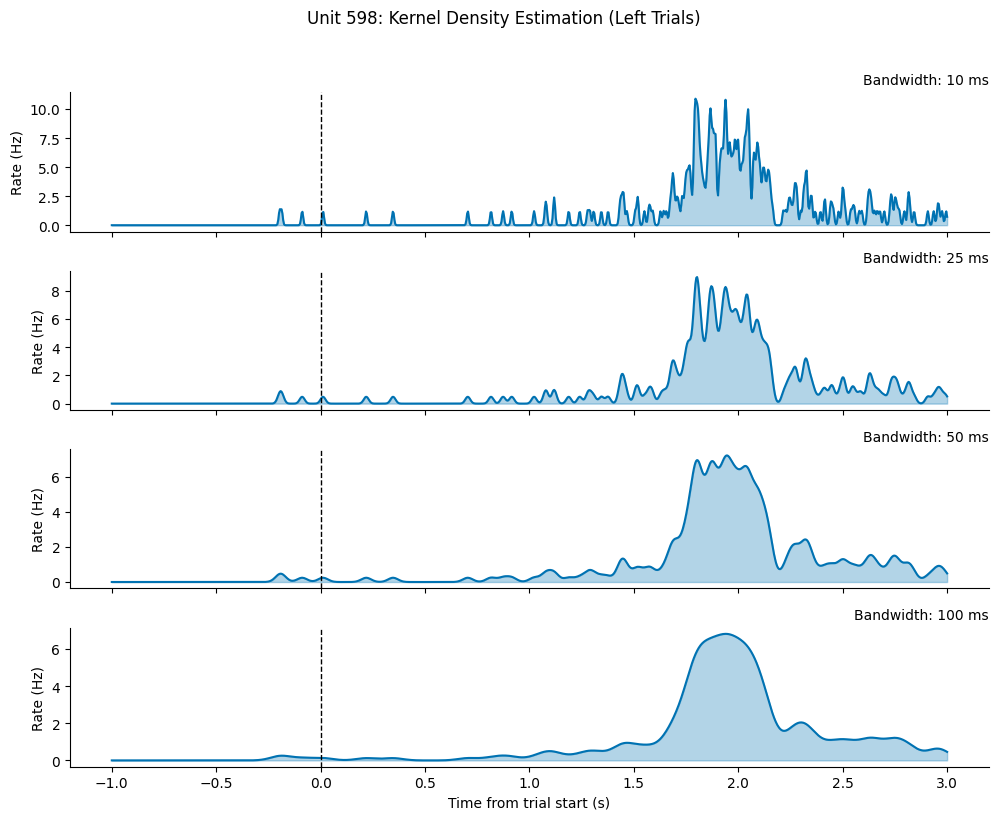

In [38]:
# Pool all spikes from left trials for KDE
all_left_spikes = np.concatenate(left_aligned)

# Create evaluation points for the KDE
eval_points = np.linspace(psth_window[0], psth_window[1], 1000)

# Compare different bandwidths
bandwidths_ms = [10, 25, 50, 100]  # in milliseconds

fig, axes = plt.subplots(len(bandwidths_ms), 1, figsize=(10, 8), sharex=True)

for ax, bw_ms in zip(axes, bandwidths_ms):
    # Convert bandwidth from ms to seconds
    bw_sec = bw_ms / 1000

    # Fit KDE with specified bandwidth (bw_method is the standard deviation)
    kde = gaussian_kde(all_left_spikes, bw_method=bw_sec)

    # Evaluate the density at our points
    # KDE returns probability density; multiply by total spike count and divide
    # by number of trials to get average firing rate (spikes/second/trial)
    density = kde(eval_points)
    firing_rate = density * len(all_left_spikes) / len(left_aligned)

    ax.fill_between(eval_points, firing_rate, alpha=0.3, color=LEFT_COLOR)
    ax.plot(eval_points, firing_rate, color=LEFT_COLOR, linewidth=1.5)
    ax.axvline(0, color="black", linestyle="--", linewidth=1)
    ax.set_ylabel("Rate (Hz)")
    ax.set_title(f"Bandwidth: {bw_ms} ms", loc="right", fontsize=10)
    ax.spines[["top", "right"]].set_visible(False)

axes[-1].set_xlabel("Time from trial start (s)")
fig.suptitle(f"Unit {unit_idx}: Kernel Density Estimation (Left Trials)", y=1.02)

plt.tight_layout()
plt.show()

Unlike binning, KDE places a Gaussian kernel centered at each spike time and sums
them to produce a continuous density estimate. This avoids bin edge artifacts and
naturally produces a smooth firing rate estimate.

The bandwidth choice depends on the timescale of the neural dynamics you want
to capture. For hippocampal place cells during navigation, bandwidths of 25-50 ms
are often appropriate, as they capture firing rate changes on the timescale of
the animal's movement through place fields.

**Caution: Boundary effects.** Notice how the firing rate estimate is attenuated
near the window edges. This occurs because KDE estimates probability density—at
the boundaries, the kernel extends beyond the data range where no spikes exist,
pulling the estimate toward zero. Be cautious when interpreting rates near window
boundaries, especially with larger bandwidths. Solutions include extending the
analysis window beyond the region of interest or using boundary-corrected kernels.

## Place Cells and Spatial Coding

**Place cells** are hippocampal neurons that fire when an animal is at a specific
location in its environment. Discovered by John O'Keefe in 1971 (Nobel Prize 2014),
place cells are thought to form the neural basis of a cognitive map.

Key properties of place cells:
- Each place cell has a **place field**: the location(s) where it fires most strongly
- Place fields tile the environment, providing a population code for location
- Place fields are stable across repeated visits to the same location
- Different environments activate different place cell populations (remapping)

To visualize spatial firing, we plot each spike at the animal's location when it
occurred. We use `np.searchsorted` to efficiently find the position index
corresponding to each spike time.

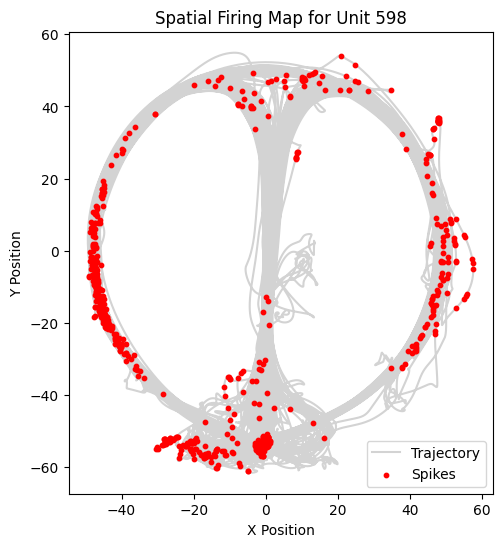

In [39]:
# Limit spike times to the position recording epoch
epoch_spike_times = spike_times[
    (spike_times >= position_timestamps.min())
    & (spike_times <= position_timestamps.max())
]
# Find position index for each spike using binary search
position_ind_at_spike = np.searchsorted(position_timestamps, epoch_spike_times)
# Clip to valid indices (handles floating-point edge cases)
position_ind_at_spike = np.clip(position_ind_at_spike, 0, len(position_timestamps) - 1)
x_position_at_spike = x_position[position_ind_at_spike]
y_position_at_spike = y_position[position_ind_at_spike]

fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(x_position, y_position, color="lightgray", label="Trajectory")
ax.scatter(
    x_position_at_spike,
    y_position_at_spike,
    color="red",
    s=10,
    label="Spikes",
    zorder=5,
)
ax.set_xlabel("X Position")
ax.set_ylabel("Y Position")
ax.set_title(f"Spatial Firing Map for Unit {unit_idx}")
ax.legend()
ax.set_aspect("equal", adjustable="box")

## Spatial Binning: From Scatter to Heatmap

The scatter plot above shows *where* spikes occurred, but it's hard to quantify
the spatial structure. We need to convert this to a **rate map** that shows firing
rate as a function of position.

The first step is **spatial binning**: dividing the environment into a grid and
counting spikes in each bin. We use 2 cm bins, which is a common choice that
balances spatial resolution against having enough spikes per bin for reliable
estimates.

The spike count map below shows the raw number of spikes in each spatial bin.
However, this is misleading because the animal spends more time in some locations
than others—more time means more opportunity for spikes, even if the firing rate
is the same everywhere.

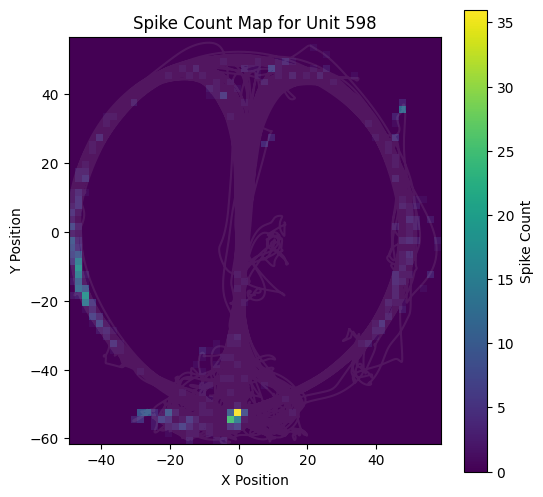

In [40]:
pos_bin_size = 2  # cm (2 cm bins)
min_x, max_x = np.nanmin(x_position), np.nanmax(x_position)
min_y, max_y = np.nanmin(y_position), np.nanmax(y_position)
x_bins = np.arange(min_x, max_x + pos_bin_size, pos_bin_size)
y_bins = np.arange(min_y, max_y + pos_bin_size, pos_bin_size)


fig, ax = plt.subplots(figsize=(6, 6))
hist_handle = ax.hist2d(x_position_at_spike, y_position_at_spike, bins=[x_bins, y_bins])
ax.set_xlabel("X Position")
ax.set_ylabel("Y Position")
ax.set_title(f"Spike Count Map for Unit {unit_idx}")
ax.set_aspect("equal", adjustable="box")
ax.plot(x_position, y_position, color="lightgray", alpha=0.1)
plt.colorbar(hist_handle[3], ax=ax, label="Spike Count")

## Occupancy Normalization

The **occupancy map** shows how much time the animal spent in each spatial bin.
This is essential for computing accurate firing rates.

Consider two locations:
- Location A: 10 spikes, animal spent 100 seconds there → 0.1 Hz
- Location B: 10 spikes, animal spent 10 seconds there → 1.0 Hz

Without occupancy normalization, both locations would appear identical (10 spikes).
With normalization, we correctly identify that the neuron fires 10x more at Location B.

On a figure-8 maze, the animal typically spends more time at the choice point
(center) and reward locations (ends), creating non-uniform occupancy that must
be accounted for.

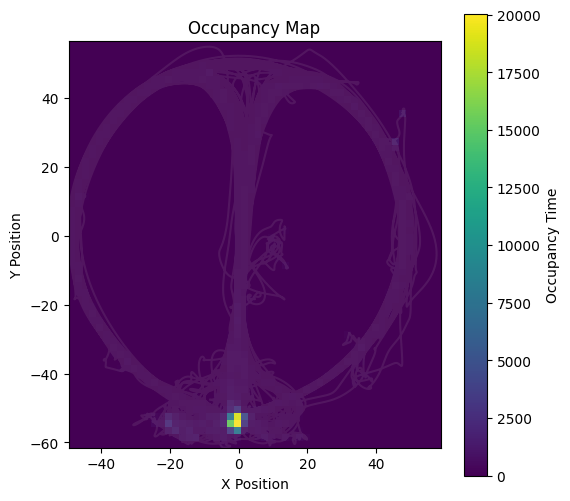

In [41]:
fig, ax = plt.subplots(figsize=(6, 6))
hist_handle = ax.hist2d(x_position, y_position, bins=[x_bins, y_bins])
ax.set_xlabel("X Position")
ax.set_ylabel("Y Position")
ax.set_title("Occupancy Map")
ax.set_aspect("equal", adjustable="box")
ax.plot(x_position, y_position, color="lightgray", alpha=0.1)
plt.colorbar(hist_handle[3], ax=ax, label="Occupancy Time")

## Computing the Place Field (Firing Rate Map)

The **firing rate map** is computed by dividing the spike count in each bin by
the occupancy time in that bin:

$$\text{Firing Rate}(x, y) = \frac{\text{Spike Count}(x, y)}{\text{Occupancy Time}(x, y)}$$

This gives us the firing rate in spikes per second (Hz) for each spatial bin.
Bins with zero occupancy (the animal never visited) are set to zero or masked.

A clear place cell will show:
- **High firing rate** (hot colors) in a localized region—the place field
- **Low firing rate** (cool colors) elsewhere
- **Sharp boundaries** rather than gradual transitions

The place field below reveals where this neuron "thinks" the animal is when it
fires. In the Petersen & Buzsáki study, these spatial correlates were preserved
even when theta oscillations were disrupted by cooling the medial septum.

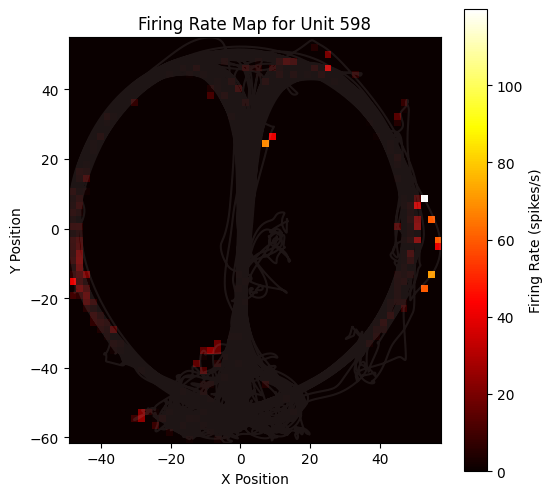

In [42]:
# Compute occupancy map
binned_occupancy, _, _ = np.histogram2d(
    x_position,
    y_position,
    bins=[x_bins, y_bins],
)

# Compute binned spikes
binned_spikes, _, _ = np.histogram2d(
    x_position_at_spike,
    y_position_at_spike,
    bins=[x_bins, y_bins],
)
# Compute firing rate map
# Convert position samples to seconds using the sampling rate
sampling_rate = 1 / np.median(np.diff(position_timestamps))  # Hz
occupancy_time = binned_occupancy / sampling_rate  # seconds per bin

with np.errstate(divide="ignore", invalid="ignore"):
    firing_rate_map = binned_spikes / occupancy_time  # spikes per second
    firing_rate_map[np.isnan(firing_rate_map)] = 0  # Set NaNs to zero (unvisited bins)

fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(
    firing_rate_map.T,
    origin="lower",
    extent=[min_x, max_x, min_y, max_y],
    aspect="equal",
    cmap="hot",
)
ax.set_xlabel("X Position")
ax.set_ylabel("Y Position")
ax.set_title(f"Firing Rate Map for Unit {unit_idx}")
ax.plot(x_position, y_position, color="lightgray", alpha=0.1)
plt.colorbar(im, ax=ax, label="Firing Rate (spikes/s)")

## Temporal Structure: Spike Train Autocorrelation

Beyond *where* a neuron fires, we can analyze *how* it fires over time. The
**autocorrelation** measures the probability of observing a spike at time lag τ
given a spike at time 0.

The autocorrelation reveals temporal structure in spike trains:

- **Refractory period** (0-2 ms): The dip near zero reflects the absolute and
  relative refractory periods when the neuron cannot fire or is less likely to fire.

- **Bursting** (2-10 ms): Peaks in this range indicate the neuron fires in rapid
  bursts. Hippocampal pyramidal cells often fire complex spike bursts of 2-7 spikes.

- **Theta rhythmicity** (100-167 ms): If the neuron is modulated by theta oscillations
  (6-10 Hz), we expect peaks at intervals of ~100-167 ms. This is a hallmark of
  hippocampal activity during active exploration.

The dotted red lines show approximate 95% confidence bounds assuming independent
spike counts. Peaks outside these lines suggest significant temporal structure,
though this is a rough guide rather than a formal statistical test.

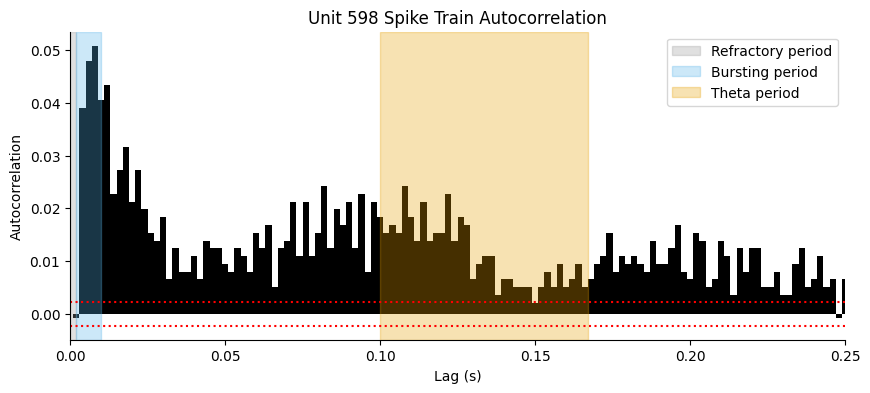

In [43]:
def autocorr(x: np.ndarray, lags: int = 100) -> np.ndarray:
    """Compute the autocorrelation of a time series.

    Parameters
    ----------
    x : np.ndarray, shape (n_samples,)
        Input time series (e.g., binned spike counts).
    lags : int
        Number of lags to compute the autocorrelation for.

    Returns
    -------
    np.ndarray, shape (lags + 1,)
        Autocorrelation coefficients for lags 0 to `lags`.
    """
    x_centered = x - np.mean(x)
    xcorr = correlate(x_centered, x_centered, mode="full")
    # Normalize by lag-0 (variance) so autocorrelation at lag 0 = 1
    xcorr = xcorr[xcorr.size // 2 :] / xcorr[xcorr.size // 2]
    return xcorr[: lags + 1]


# Create binned spike count for autocorrelation
autocorr_bin_size = 0.002  # seconds (2 ms bins)
n_bins = int(
    np.ceil((position_timestamps.max() - position_timestamps.min()) / autocorr_bin_size)
)
binned_spike_counts, bin_edge_times = np.histogram(
    epoch_spike_times,
    bins=n_bins,
    range=(position_timestamps.min(), position_timestamps.max()),
)
n_lags = 125  # 250 ms window (covers ~2 theta cycles at 8 Hz)
spike_train_autocorr = autocorr(binned_spike_counts, n_lags)

fig, ax = plt.subplots(figsize=(10, 4))
lags = np.arange(n_lags + 1) * autocorr_bin_size
# exclude lag 0 for better visualization of rhythmicity
ax.bar(lags[1:], spike_train_autocorr[1:], width=autocorr_bin_size, color="black")
sig = 2 / np.sqrt(n_bins)  # Approximate 95% bounds (assumes independence)
ax.plot([0, lags[-1]], [sig, sig], "r:")  # upper and lower significance lines
ax.plot([0, lags[-1]], [-sig, -sig], "r:")
ax.set_xlabel("Lag (s)")
ax.set_ylabel("Autocorrelation")
ax.set_title(f"Unit {unit_idx} Spike Train Autocorrelation")
ax.set_xlim(0, lags[-1])
ax.axvspan(0.0, 0.002, color="#999999", alpha=0.3, label="Refractory period")  # gray
ax.axvspan(0.002, 0.01, color="#56B4E9", alpha=0.3, label="Bursting period")  # sky blue
ax.axvspan(0.100, 0.167, color="#E69F00", alpha=0.3, label="Theta period")  # orange
ax.legend(loc="upper right")
ax.spines[["top", "right"]].set_visible(False)

## Statistical Models of ISI Distributions

The simplest model for neural spiking is the **Poisson process**, where spikes
occur independently at a constant rate. For a Poisson process, the inter-spike
intervals follow an **exponential distribution**:

$$P(\text{ISI} = t) = \lambda e^{-\lambda t}$$

where $\lambda$ is the firing rate (spikes per second).

Let's fit this model to our ISI data and see how well it describes real neural
activity. If the fit is good, the neuron fires like a Poisson process. If not,
the deviations reveal interesting structure (e.g., refractory period, bursting).

Estimated firing rate (λ): 9.5 Hz
Mean ISI: 105.6 ms


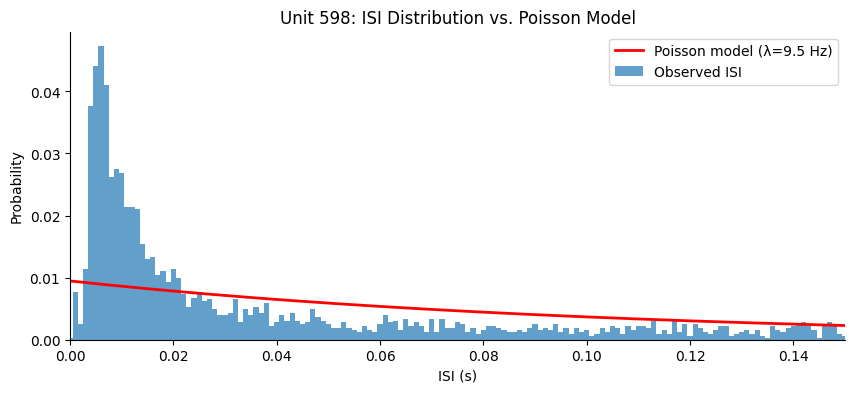

In [44]:
# Recompute ISIs for the full distribution
isi = np.diff(spike_times)
isi = isi[isi < 0.5]  # Focus on ISIs < 500 ms

# Compute ISI histogram as probability
isi_bins = np.arange(0, 0.5, 0.001)  # 1 ms bins
counts, _ = np.histogram(isi, bins=isi_bins)
prob = counts / len(isi)  # Convert counts to probability

# Fit the exponential model: lambda = 1 / mean(ISI)
lbda = 1 / isi.mean()  # Maximum likelihood estimate for exponential distribution

# Compute the theoretical exponential distribution
# P(ISI in bin) = lambda * exp(-lambda * t) * bin_width
bin_width = isi_bins[1] - isi_bins[0]
model = lbda * np.exp(-lbda * isi_bins) * bin_width

# Plot the comparison
fig, ax = plt.subplots(figsize=(10, 4))
ax.bar(isi_bins[:-1], prob, width=bin_width, alpha=0.7, label="Observed ISI")
ax.plot(isi_bins, model, "r-", linewidth=2, label=f"Poisson model (λ={lbda:.1f} Hz)")
ax.set_xlim(0, 0.15)
ax.set_xlabel("ISI (s)")
ax.set_ylabel("Probability")
ax.set_title(f"Unit {unit_idx}: ISI Distribution vs. Poisson Model")
ax.legend()
ax.spines[["top", "right"]].set_visible(False)

print(f"Estimated firing rate (λ): {lbda:.1f} Hz")
print(f"Mean ISI: {isi.mean() * 1000:.1f} ms")

Notice the deviations from the Poisson model:

1. **Refractory period** (0-2 ms): Real neurons cannot fire immediately after
   a spike due to the absolute refractory period. The Poisson model predicts
   many short ISIs that don't occur in real data.

2. **Bursting** (2-10 ms): Many neurons show an excess of short ISIs compared
   to the Poisson prediction, indicating they fire in bursts.

3. **Long ISIs**: The exponential model may overpredict or underpredict long
   intervals depending on whether the neuron has periods of silence.

The Poisson model serves as a useful **null hypothesis**: deviations from it
reveal interesting neural dynamics. More sophisticated models (e.g., refractory
Poisson, gamma distribution) can capture these features.

## Exercises

Try these on your own to deepen your understanding of spike-stimulus analysis:

1. **Explore different units**: Change `good_unit_indices[3]` to analyze a different
   unit. Do all units have clear place fields? How do the firing rates vary?

2. **Bin size effects**: Try different values for `pos_bin_size` (e.g., 1 cm, 5 cm).
   How does bin size affect the appearance of the place field? What are the tradeoffs?

3. **ISI quality check**: Examine the ISI histogram. Are there any spikes with
   intervals less than 1 ms? What would this indicate about unit isolation?

4. **Theta modulation**: Look at the autocorrelation plot. Is there a peak around
   125 ms (8 Hz theta)? Compare this to a unit with no theta modulation.

5. **Peak firing rate**: What is the maximum firing rate in the place field?
   (Hint: use `np.nanmax(firing_rate_map)`)

6. **Place field size**: How would you quantify the size of the place field?
   One approach: count bins where firing rate exceeds 20% of the maximum.

7. **Find a putative interneuron**: Hippocampal interneurons typically have much
   higher firing rates than pyramidal cells (>10 Hz vs ~1 Hz). Find a unit with
   a high firing rate and compare its autocorrelogram and place rate map to the
   pyramidal cell above. Interneurons often lack clear place fields and show
   different temporal firing patterns (e.g., less bursting, different theta modulation).

8. **Multiunit firing rate**: Combine spikes from all good units to compute a
   population firing rate over time. Bin all spikes into 20 ms windows and plot
   the firing rate. Do you see periods of high and low activity? How does the
   population rate relate to the animal's speed? What happens during immobility
   vs running? (Hint: use `np.concatenate` to combine spike times, then
   `np.histogram` to bin them.)

## Summary

In this notebook, we learned how to:

1. **Load and align spike times with position data** from an NWB file
2. **Assess unit quality** using ISI distributions
3. **Build a PSTH** to analyze trial-aligned neural activity
4. **Visualize spatial firing** by plotting spikes at their corresponding locations
5. **Compute place fields** using spatial binning and occupancy normalization
6. **Analyze temporal structure** with spike train autocorrelation
7. **Fit statistical models** to ISI distributions (Poisson/exponential)

### Key Concepts

| Concept | Description |
|---------|-------------|
| PSTH | Average firing rate aligned to repeated behavioral events |
| Place cell | Hippocampal neuron that fires at specific locations |
| Place field | The spatial region where a place cell fires most strongly |
| ISI distribution | Time intervals between consecutive spikes |
| Occupancy normalization | Correcting for unequal time spent at different locations |
| Autocorrelation | Temporal structure in spike trains (bursting, theta modulation) |
| Poisson process | Statistical model where spikes occur independently at constant rate |

### Python Techniques Used

- **`np.searchsorted`** for efficient spike-to-position alignment
- **`np.histogram2d`** for 2D spatial binning
- **`scipy.signal.correlate`** for computing autocorrelation
- **Boolean masking** for filtering spikes to behavioral epochs
- **`np.errstate`** for handling division by zero gracefully

### Next Steps

In Week 3, we'll analyze the **local field potential (LFP)** and its spectral
properties. We'll examine theta oscillations, which coordinate the timing of
place cell spikes and are critical for navigation. The Petersen & Buzsáki study
showed that theta phase—not clock time—organizes hippocampal cell assemblies.

## Cleanup

In [45]:
io.close()